# Exploratory Data Analysis

## import packages

In [207]:
import sys
sys.path.append("/Users/lesleymi/data_science_tutorials/IMDB_Sentiment_Analysis/src")
# custom functions
import imdb_functions as imdb

# data wrangling
import pandas as pd
import numpy as np

# nlp
from nltk.probability import FreqDist

# viz
import plotly.express as px
from keplergl import KeplerGl

# Plotly Dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc

## load train set

In [208]:
train = pd.read_csv("data/Train.csv")
train_clean = pd.read_csv("data/train_clean.csv")

# replace 0/1s with human readable labels
train = train.replace({'label':{0:'negative',
                                1: 'positive'}})

In [209]:
# look at raw train
train.head(3)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,negative
1,"When I put this movie in my DVD player, and sa...",negative
2,Why do people who do not know what a particula...,negative


In [210]:
# look at clean train
train_clean.head(3)

,Unnamed: 0,text,label
0,0,grow watch love thunderbirds mate school watch...,0
1,1,movie dvd player sit coke chip expectation hop...,0
2,2,people know particular time past like feel nee...,0


In [211]:
print("Number of observations: {}".format(train.shape[0]))
print("Number of unique labels: {}".format(train.label.nunique()))
print("The unique labels are: {0} and {1}".format(train.label.unique()[0],
                                                 train.label.unique()[1]))

Number of observations: 40000
Number of unique labels: 2
The unique labels are: negative and positive


## look at example of a neg review

In [212]:
# get a negative review 
neg_rev = train.query('label == "negative"').text[0]

## look at example of a pos review

In [213]:
# get a positive review 
pos_rev = train.query('label == "positive"').text.values[1]


**There are `html` tags present in the data here; this will have to be removed during data cleaning.**

## Visualize count of pos/neg

In [214]:
# how many positive/negative reviews are there? 
df = (train.groupby(by='label')
          .count()
          .reset_index()
          .rename(columns={'text':'count'}))
df


,label,count
0,negative,20019
1,positive,19981


The visualization of positive vs negative review counts indicates a balanced dataset with
the count of positive reviews nearly equal to the count of negative reviews.

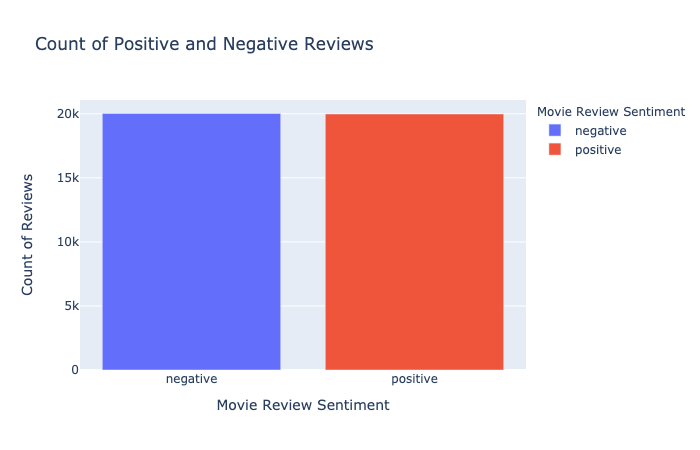

In [215]:
# plot he count of pos/neg labels
plot1 = px.bar(df,
       x='label',
       y='count',
       color='label',
       title='Count of Positive and Negative Reviews',
       labels={'label': 'Movie Review Sentiment',
               'count': 'Count of Reviews'})
plot1.show('png')

In [216]:
# convert documents into list of tokens
docs = imdb.tokenize(text=train.text)

In [217]:
# convert clean documents into list of tokens
clean_docs = imdb.tokenize(text=train_clean.text)

In [218]:
# convert list of docs to series
docs = pd.Series(docs)

# get number of tokens in each document
doc_length = docs.apply(func=len).to_frame(name='num_tokens')
doc_length.head()

,num_tokens
0,173
1,398
2,209
3,76
4,208


In [219]:
# convert list of docs to series
clean_docs = pd.Series(clean_docs)

# get number of tokens in each document
clean_doc_length = clean_docs.apply(func=len).to_frame(name='num_tokens')
clean_doc_length.head()

,num_tokens
0,75
1,132
2,84
3,27
4,86


In [220]:
# add document length to text df
train['num_tokens'] = doc_length
# add tokenized docs to train df
train['tokenized_docs'] = docs
train.head(3)

,text,label,num_tokens,tokenized_docs
0,I grew up (b. 1965) watching and loving the Th...,negative,173,"[I, grew, up, (, b., 1965, ), watching, and, l..."
1,"When I put this movie in my DVD player, and sa...",negative,398,"[When, I, put, this, movie, in, my, DVD, playe..."
2,Why do people who do not know what a particula...,negative,209,"[Why, do, people, who, do, not, know, what, a,..."


In [221]:
# add document length to text df
train_clean['num_tokens'] = clean_doc_length
# add tokenized docs to train df
train_clean['tokenized_docs'] = clean_docs
train_clean.head(3)



,Unnamed: 0,text,label,num_tokens,tokenized_docs
0,0,grow watch love thunderbirds mate school watch...,0,75,"[grow, watch, love, thunderbirds, mate, school..."
1,1,movie dvd player sit coke chip expectation hop...,0,132,"[movie, dvd, player, sit, coke, chip, expectat..."
2,2,people know particular time past like feel nee...,0,84,"[people, know, particular, time, past, like, f..."


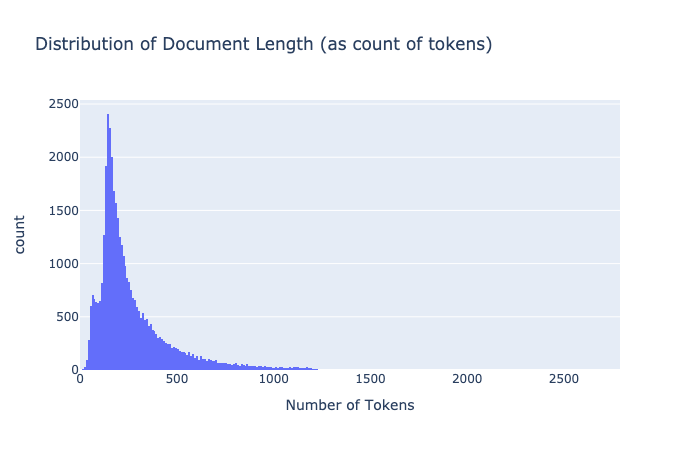

In [222]:
plot2 = px.histogram(doc_length,
                     x='num_tokens',
                     title='Distribution of Document Length (as count of tokens)',
                     labels={'num_tokens': 'Number of Tokens'})
plot2.show('png')


In [223]:
# how many words in the corpus in total?
print("There are {0} total tokens in the corpus.".format(train.num_tokens.sum()))
print("There are {0} total tokens in the cleaned corpus.".format(train_clean.num_tokens.sum()))

There are 10782557 total tokens in the corpus.
There are 4010988 total tokens in the cleaned corpus.


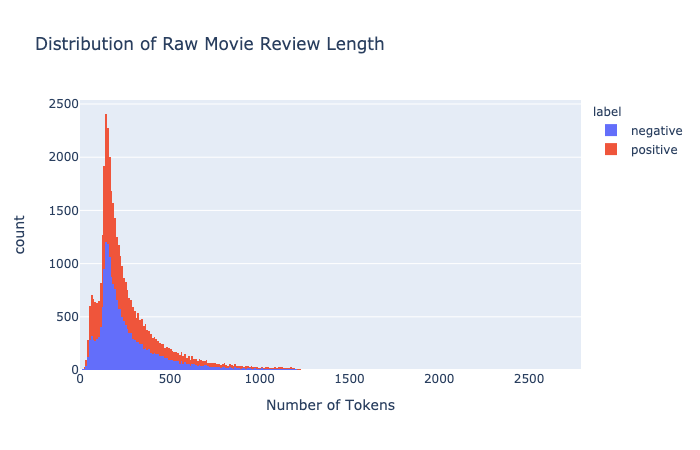

In [224]:
# visualize document length by sentiment label
plot3 = px.histogram(train,
                     x='num_tokens',
                     color='label',
                     labels={'num_tokens':'Number of Tokens'},
                     title='Distribution of Raw Movie Review Length')
plot3.show('png')

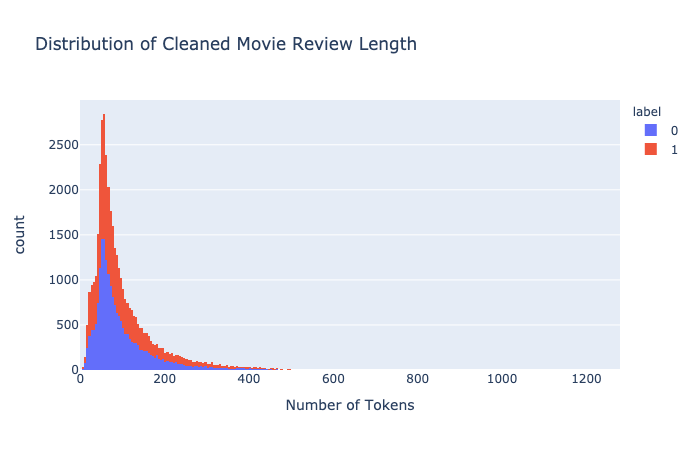

In [225]:
# visualize document length by sentiment label
plot4 = px.histogram(train_clean,
                     x='num_tokens',
                     color='label',
                     labels={'num_tokens':'Number of Tokens'},
                     title='Distribution of Cleaned Movie Review Length')
plot4.show('png')



## Most common words overall

In [226]:
# combine the documents into a single bag of words
clean_docs_bow = np.concatenate(train_clean.tokenized_docs)


In [227]:
most_common = pd.Series(FreqDist(clean_docs_bow).most_common(10))

In [228]:
# create dict out of the most common words
most_common_dict = {}
for i in most_common:
    most_common_dict[i[0]] = i[1]

In [229]:
# convert dict to df
most_common_df = pd.DataFrame(most_common_dict,
                              index=[0]).transpose().reset_index()
most_common_df.columns = ['most_common_words', 'count']
most_common_df.head()

,most_common_words,count
0,movie,80866
1,film,74945
2,like,35331
3,time,24767
4,good,23599


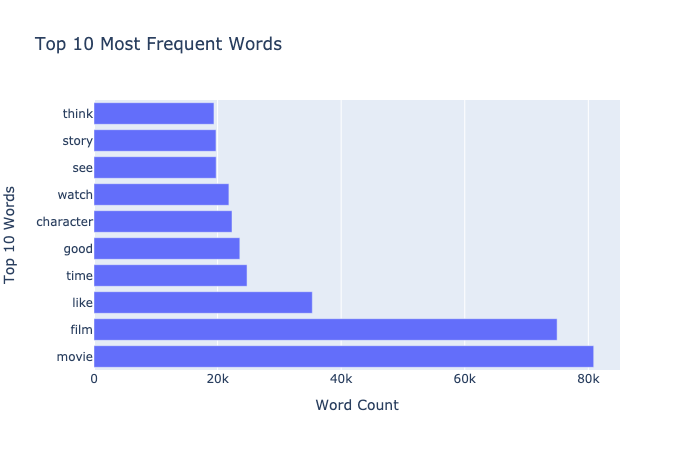

In [230]:
plot5 = px.bar(most_common_df,
               x='count',
               y='most_common_words',
               labels={'most_common_words':'Top 10 Words',
                       'count':'Word Count'},
               title='Top 10 Most Frequent Words')
plot5.show('png')


## Most common words in pos/neg reviews

In [231]:
# filter for pos/neg reviews
train_clean_pos = train_clean.query('label == 1').tokenized_docs.to_list()
train_clean_neg = train_clean.query('label == 0').tokenized_docs.to_list()

# combine the documents into a single bag of words
positive_bow = np.concatenate(train_clean_pos)
negative_bow = np.concatenate(train_clean_neg)

In [232]:
# get counts of most common positive words 
most_common_pos = pd.Series(FreqDist(positive_bow).most_common(10))

# create dict out of the most common words
most_common_dict_pos = {}
for i in most_common_pos:
    most_common_dict_pos[i[0]] = i[1]
    
# convert dict to df
most_common_df_pos = pd.DataFrame(most_common_dict_pos,
                              index=[0]).transpose().reset_index()
most_common_df_pos.columns = ['most_common_words', 'count']
most_common_df_pos.head()

,most_common_words,count
0,film,39839
1,movie,35182
2,like,16096
3,time,12839
4,good,11857


In [233]:
# get counts of most common negatige words 
most_common_neg = pd.Series(FreqDist(negative_bow).most_common(10))

# create dict out of the most common words
most_common_dict_neg = {}
for i in most_common_neg:
    most_common_dict_neg[i[0]] = i[1]
    
# convert dict to df
most_common_df_neg = pd.DataFrame(most_common_dict_neg,
                              index=[0]).transpose().reset_index()
most_common_df_neg.columns = ['most_common_words', 'count']
most_common_df_neg.head()

,most_common_words,count
0,movie,45684
1,film,35106
2,like,19235
3,time,11928
4,watch,11750


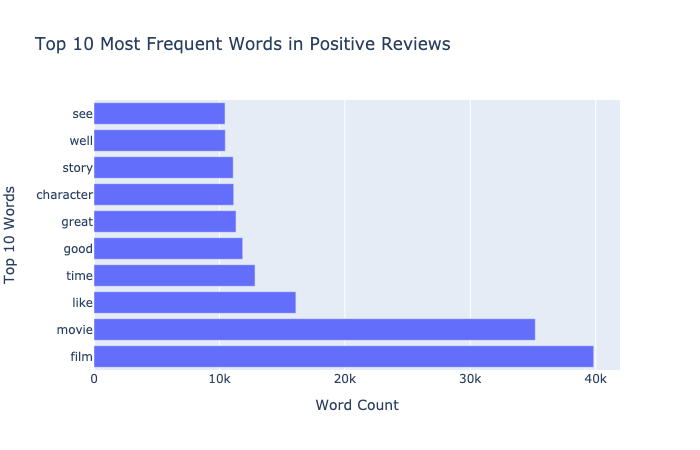

In [234]:
plot6 = px.bar(most_common_df_pos,
               x='count',
               y='most_common_words',
               labels={'most_common_words':'Top 10 Words',
                       'count':'Word Count'},
               title='Top 10 Most Frequent Words in Positive Reviews')
plot6.show('png')


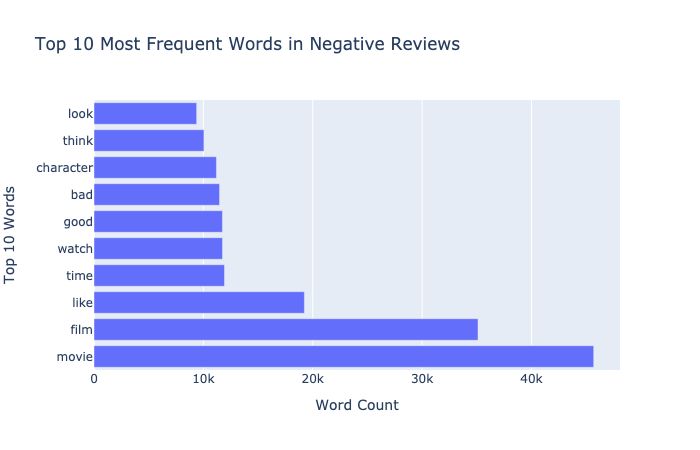

In [235]:
plot7 = px.bar(most_common_df_neg,
               x='count',
               y='most_common_words',
               labels={'most_common_words':'Top 10 Words',
                       'count':'Word Count'},
               title='Top 10 Most Frequent Words in Negative Reviews')
plot7.show('png')


In [ ]:
kepler_map = KeplerGl(height=300)
kepler_map.save_to_html(file_name='base_map.html')

## Build Dashboard

In [ ]:
external_stylesheets = [dbc.themes.CERULEAN]
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# add positive and negative review examples to a table
table_header = [html.Thead(
    html.Tr([html.Th("Positive Review"), html.Th('Negative Review')])
)]
row1 = html.Tr([html.Td(pos_rev), html.Td(neg_rev)])
table_body = [html.Tbody([row1])]
table = dbc.Table(table_header + table_body,
                  bordered=True,
                  striped=True)


# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div(children=[html.H1(children='IMDB Movie Reviews'),
                                html.H2(children='Exploratory Text Analysis'),
                                dbc.Container(
                                    [dbc.Row(table),
                                     dbc.Row([dbc.Col(dcc.Graph(id='plot1', figure=plot1)),
                                             dbc.Col(dcc.Graph(id='plot3', figure=plot3))]),
                                     dbc.Row([dbc.Col(dcc.Graph(id='plot5', figure=plot5)),
                                             dbc.Col(dcc.Graph(id='plot6', figure=plot6)),
                                             dbc.Col(dcc.Graph(id='plot7', figure=plot7))]),],
                                fluid=True)
                                ])




In [237]:
app.run_server()


Dash app running on http://127.0.0.1:8050/
